# **<span style="color: #87CEEB;"> Pixel CNN</span>**
# <span style="color: #9370DB;">**Deep Learning 2025**</span>

# PixelCNN Implementation using Pytorch <span style="color: #9370DB;"></span></b></h1> 

## **Introduction**
This project explores **PixelCNN**, a deep learning model designed for **generating images pixel-by-pixel** using **autoregressive modeling**. We apply this model to the **MNIST dataset**, which consists of handwritten digits, to understand how PixelCNN learns pixel dependencies and generates realistic digit images.

## **Objectives**
- Implement **PixelCNN** using TensorFlow/Keras.  
- Preprocess the **MNIST dataset** for binary pixel values.  
- Define custom **Pixel Convolutional Layers** and **Residual Blocks**.  
- Train the model to **generate images sequentially pixel by pixel**.  
- Evaluate model performance and visualize generated images.  

## **Dataset**
The **MNIST dataset** contains:
- **60,000 training images**  
- **10,000 testing images**  
Each image is **28×28 pixels** and represents a digit from **0 to 9**.

### Import Necessary Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# import tensorflow
# from tensorflow.keras.datasets import mnist
from IPython.display import Image, display
from tqdm import tqdm_notebook
from torchsummary import summary


# I have used pytorch for this project instead of tensorflow
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

### Visualize the Dataset

Training data shape (raw): torch.Size([60000, 28, 28])
Testing data shape (raw): torch.Size([10000, 28, 28])


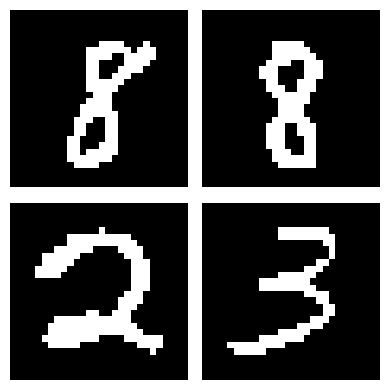

In [ ]:
def load_and_plot(num_samples):
    """
    Load the MNIST dataset, print the dataset shapes, and plot a grid of random images from the training set.

    Parameters:
    num_samples (int): Number of images to plot in a grid.
    """
    transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x > 0.5).float()
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    print("Training data shape (raw):", train_dataset.data.shape)
    print("Testing data shape (raw):", test_dataset.data.shape)

    indices = np.random.choice(len(train_dataset), num_samples, replace=False)
    images = [train_dataset[i][0].squeeze() for i in indices]

    grid_size = int(np.sqrt(num_samples))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))

    for ax, img in zip(axes.flatten(), images):
        ax.imshow(img, cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

load_and_plot(num_samples=4)


### Preprocess the Dataset  

- Apply **binarization** to the images: Convert pixel values to either 0 or 1 based on a chosen threshold.  
- Convert the dataset to **float32** for compatibility with the model.  
- Reshape the dataset to include a **single channel** for grayscale images.  
- Print the **shapes** of the training and testing datasets to verify the preprocessing steps.  


In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using", device)

transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x > 0.5).float()
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print("Raw training data shape:", train_dataset.data.shape)
print("Raw testing data shape:", test_dataset.data.shape)

sample_image, sample_label = train_dataset[0]
print("Processed sample image shape:", sample_image.shape)

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset1, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Using MPS device
Raw training data shape: torch.Size([60000, 28, 28])
Raw testing data shape: torch.Size([10000, 28, 28])
Processed sample image shape: torch.Size([1, 28, 28])


### Implement `PixelConv` Class

1. **Initialize the Layer:**  
   - Define a convolutional layer with the given parameters.  
   - Store the mask type ('A' or 'B') as an instance variable.  

2. **Create a Mask in the `setup_layer` Method:**  
   - Generate a mask matrix that ensures autoregressive pixel dependencies.  
   - Implement different masking rules for **Mask Type A and Mask Type B**.  

3. **Apply the Mask in the `apply_mask` Method:**  
   - Multiply the convolution kernel with the mask before computing outputs.  
   - Ensure the layer respects the masked constraints during forward pass.  


In [ ]:
class PixelConv(nn.Module):
    def __init__(self, mask_type, **kwargs):
        super(PixelConv, self).__init__()
        self.mask_type = mask_type
        self.conv = nn.Conv2d(**kwargs)
        kernel_size = kwargs.get("kernel_size", 3)
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        # put in register not a trainable parameter so no updates needed during backprop
        self.register_buffer('mask', self.setup_layer(self.conv.weight.shape))

    def setup_layer(self, input_shape):
        kH, kW = self.kernel_size
        mask = torch.ones_like(self.conv.weight)
        center_h = kH // 2
        center_w = kW // 2
        mask[:, :, center_h+1:, :] = 0
        mask[:, :, center_h, center_w+1:] = 0
        if self.mask_type == 'A':
            mask[:, :, center_h, center_w] = 0
        return mask

    def apply_mask(self):
        self.conv.weight.data *= self.mask

### Implement a Residual Block for PixelCNN

A residual block helps improve training stability and allows better gradient flow by adding shortcut connections. In this class, you will define a residual block using convolutional layers and a masked convolution.

### Steps to Implement:

1. **Initialize the Layers**  
   - Define convolutional layers and a masked convolutional layer.  
   - Ensure the masked convolution follows the correct masking strategy.  

2. **Forward Pass**  
   - Pass the input through the layers sequentially.  
   - Implement the residual connection by combining the input and output.  

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        # your code here
        self.conv1 = nn.Conv2d(filters, filters, kernel_size=1, stride=1, padding=0)
        self.masked_conv = PixelConv(mask_type='B',in_channels=filters,out_channels=filters,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(filters, filters, kernel_size=1, stride=1, padding=0)
        self.activation = nn.ReLU()

    def forward(self, inputs):
        # your code here
        out = self.activation(inputs)
        out = self.conv1(out)
        out = self.activation(out)
        self.masked_conv.apply_mask()
        out = self.masked_conv.conv(out)
        out = self.activation(out)
        out = self.conv2(out)
        return out + inputs


### Putting it Together

Now you will build a PixelCNN model using masked convolutions and residual blocks to model pixel dependencies.

### To-Do:
1. **Define the input layer** for grayscale images.  
2. **Add an initial masked convolution** to process input features.  
3. **Stack multiple residual blocks** to refine the learned representations.  
4. **Include additional masked convolutions** to further process the data.  
5. **Create an output layer** that predicts pixel values.  
6. **Ensure the total parameter count remains within 600,000.**  
7. **Display a summary** of your model and verify its structure and parameters.

In [ ]:
# your code here
class PixelCNN(nn.Module):
    def __init__(self, num_residual_blocks=5, filters=16):
        super(PixelCNN, self).__init__()
        self.initial_conv = PixelConv(mask_type='A',in_channels=1,out_channels=filters,kernel_size=7,padding=3)
        self.residual_blocks = nn.ModuleList([ResidualBlock(filters=filters) for _ in range(num_residual_blocks)])
        self.additional_conv = PixelConv(mask_type='B',in_channels=filters,out_channels=filters,kernel_size=3,padding=1)
        self.output_conv = nn.Conv2d(filters, 1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        self.initial_conv.apply_mask()
        out = self.initial_conv.conv(x)
        for block in self.residual_blocks:
            out = block(out)
        out = torch.relu(out)
        self.additional_conv.apply_mask()
        out = self.additional_conv.conv(out)
        out = torch.relu(out)
        out = self.output_conv(out)
        out = torch.sigmoid(out)
        return out


In [ ]:
modeltemp = PixelCNN(num_residual_blocks=10, filters=64)
modeltemp.to("cpu")
summary(modeltemp, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           3,200
              ReLU-2           [-1, 64, 28, 28]               0
            Conv2d-3           [-1, 64, 28, 28]           4,160
              ReLU-4           [-1, 64, 28, 28]               0
            Conv2d-5           [-1, 64, 28, 28]          36,928
              ReLU-6           [-1, 64, 28, 28]               0
            Conv2d-7           [-1, 64, 28, 28]           4,160
     ResidualBlock-8           [-1, 64, 28, 28]               0
              ReLU-9           [-1, 64, 28, 28]               0
           Conv2d-10           [-1, 64, 28, 28]           4,160
             ReLU-11           [-1, 64, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          36,928
             ReLU-13           [-1, 64, 28, 28]               0
           Conv2d-14           [-1, 64,

### Train your PixelCNN
You will now train the PixelCNN model and visualize its performance.

### To-Do:
1. **Compile the model** with an appropriate optimizer and loss function.  
2. **Train the model** for three different epoch settings: **10, 20, and 30**.  
3. **Plot the training and validation loss** for all three variations to analyze model performance over epochs.

In [ ]:
model = PixelCNN(num_residual_blocks=10, filters=64)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters:", params)
model.to(device)
total_epochs = 30
checkpoint_epochs = [10, 20, 30]
overall_train_losses = []
overall_val_losses = {}
generated_images = {}
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def generate_images(model, num_images=4, image_size=(28,28)):
    model.eval()
    generated = torch.zeros((num_images, 1, image_size[0], image_size[1])).to(device)

    for i in range(image_size[0]):
        for j in range(image_size[1]):
            with torch.no_grad():
                preds = model(generated)
                pixel_probs = preds[:, 0, i, j]

                # outputs = model(generated)
                # means = outputs[:, 0, i, j]
                # log_vars = outputs[:, 1, i, j]
                # stds = torch.exp(0.5 * log_vars)
                # sampled = torch.normal(means, stds)

                sampled = torch.bernoulli(pixel_probs)
                generated[:, 0, i, j] = sampled
    return generated.cpu()

for epoch in range(total_epochs):
    model.train()
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    overall_train_losses.append(epoch_train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            running_val_loss += loss.item() * images.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    overall_val_losses[epoch+1] = epoch_val_loss

    print(f"Epoch {epoch+1}/{total_epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")

    if (epoch+1) in checkpoint_epochs:
        gen_imgs = generate_images(model, num_images=4, image_size=(28,28))
        generated_images[epoch+1] = gen_imgs

Total trainable parameters: 492673
Epoch 1/30 - Train Loss: 0.1056 - Val Loss: 0.0900
Epoch 2/30 - Train Loss: 0.0877 - Val Loss: 0.0877
Epoch 3/30 - Train Loss: 0.0855 - Val Loss: 0.0851
Epoch 4/30 - Train Loss: 0.0841 - Val Loss: 0.0838
Epoch 5/30 - Train Loss: 0.0830 - Val Loss: 0.0826
Epoch 6/30 - Train Loss: 0.0821 - Val Loss: 0.0821
Epoch 7/30 - Train Loss: 0.0815 - Val Loss: 0.0814
Epoch 8/30 - Train Loss: 0.0810 - Val Loss: 0.0813
Epoch 9/30 - Train Loss: 0.0805 - Val Loss: 0.0807
Epoch 10/30 - Train Loss: 0.0801 - Val Loss: 0.0811
Epoch 11/30 - Train Loss: 0.0798 - Val Loss: 0.0804
Epoch 12/30 - Train Loss: 0.0795 - Val Loss: 0.0802
Epoch 13/30 - Train Loss: 0.0792 - Val Loss: 0.0812
Epoch 14/30 - Train Loss: 0.0790 - Val Loss: 0.0798
Epoch 15/30 - Train Loss: 0.0788 - Val Loss: 0.0796
Epoch 16/30 - Train Loss: 0.0786 - Val Loss: 0.0795
Epoch 17/30 - Train Loss: 0.0784 - Val Loss: 0.0793
Epoch 18/30 - Train Loss: 0.0783 - Val Loss: 0.0792
Epoch 19/30 - Train Loss: 0.0780 - Val

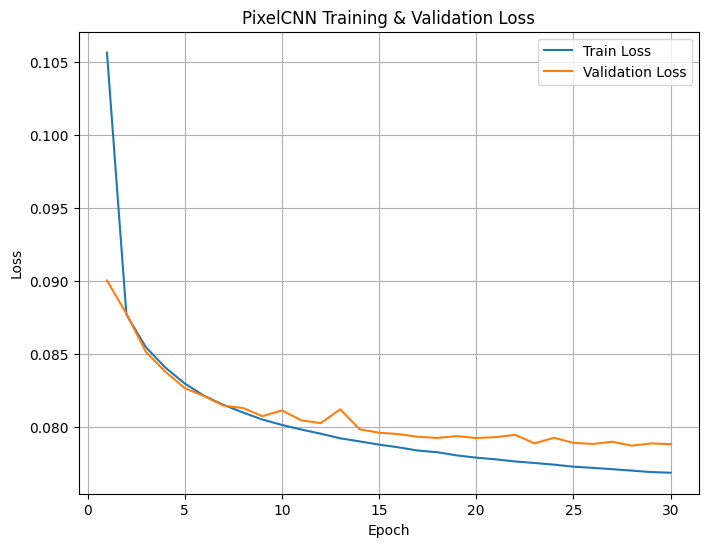

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, total_epochs+1), overall_train_losses, label='Train Loss')
plt.plot(list(overall_val_losses.keys()), list(overall_val_losses.values()), label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("PixelCNN Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

You will generate images pixel by pixel using three different trained PixelCNN models:  
- Model trained for **10 epochs**  
- Model trained for **20 epochs**  
- Model trained for **30 epochs**  

Each model will sequentially predict pixel values to generate new images.  

### To-Do:  
1. **Set up the necessary structure** for image generation.  
2. **Leverage the trained model** to infer missing pixel values step by step.  
3. **Determine pixel values** based on predictions.  
4. **Run the process with different models** and observe the outcomes.  
5. **Compare the generated images** to analyze any differences.

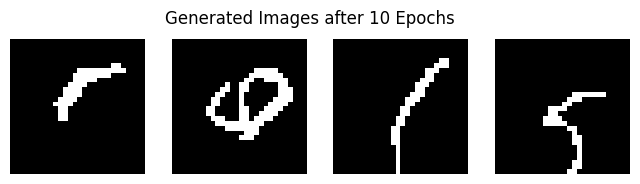

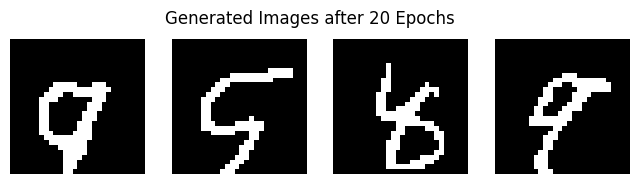

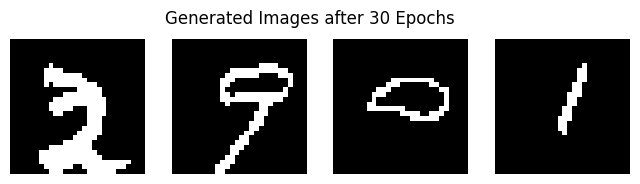

In [ ]:
def plot_generated_images(images, title):
    num_images = images.shape[0]
    plt.figure(figsize=(num_images*2, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i, 0], cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

for epoch in checkpoint_epochs:
    plot_generated_images(generated_images[epoch], f"Generated Images after {epoch} Epochs")

## Reflection Questions  

After completing this part, take some time to reflect on the following questions:    


1. **How do the generated images differ across models trained for 10, 20, and 30 epochs?** What patterns or improvements do you notice with more training? 

Answer: With fewer epochs , the model’s outputs tend to be less coherent: the digits look incomplete or have extra noise/pixels that don’t form a recognizable shape. By 20 epochs, you can see clearer digit outlines and fewer stray artifacts, although some samples still look warped or incomplete. By 30 epochs, the shapes generally become more defined—digits are more continuous and recognizable. There are still minor deformities, but for the most part, the numbers are distinguishable. In short, longer training usually leads to sharper, more coherent digit shapes and less random noise in the generated images. The generated pixels in the first 10 epoches clearly have a lack of direction since the numbers are pretty much indistiguishable. After 20 though, we can start to tell which number is which further indicating that longer training times lead to better image generation with pixel cnn.

2. **What role does the masked convolution play in PixelCNN?** How does it influence the way images are generated?

Answer: Masked convolution is essential in PixelCNN as it enforces an autoregressive structure by ensuring that each pixel is generated based solely on previously generated pixels. The mask prevents the convolution from accessing "future" pixels during training and inference, thereby preserving the correct pixel order. This approach, using Mask A in the initial layer and Mask B in subsequent layers, guarantees that the model learns dependencies only from past pixels, allowing for sequential, pixel-by-pixel image generation without leakage of future information.